<b>Data mining project - 2020/21</b><br>
<b>Author</b>: [Alexandra Bradan](https://github.com/alexandrabradan)<br>
<b>Python version</b>: 3.x<br>
<b>Last update: 20/11/2020<b>

In [79]:
%matplotlib inline

# general libraries
import sys
import math
import operator
import itertools
import pydotplus
import collections
import missingno as msno
from pylab import MaxNLocator
from collections import Counter
from collections import defaultdict
from IPython.display import Image

# pandas libraries
import pandas as pd
from pandas import DataFrame
from pandas.testing import assert_frame_equal

# visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot

# numpy libraries
import numpy as np
from numpy import std
from numpy import mean
from numpy import arange
from numpy import argmax
from numpy import unique
from numpy import percentile

# scipy libraries
import scipy.stats as stats
from scipy.stats import kstest
from scipy.stats import normaltest

# sklearn libraries
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer  # explicitly require this experimental feature
from sklearn.impute import IterativeImputer

from sklearn import tree
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.pipeline import make_pipeline as imbmake_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, recall_score, precision_score, classification_report, roc_auc_score 

In [80]:
data_directory = "../../data/"
plot_directory = "../../../plots/DataUnderstanding/"
TR_file = data_directory + "Train_HR_Employee_Attrition.csv"
TR_cleaned_file = data_directory + "Cleaned_Train_HR_Employee_Attrition.csv"
TS_file = data_directory + "Test_HR_Employee_Attrition.csv"

In [81]:
df = pd.read_csv(TS_file, sep=",") 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       258 non-null    float64
 1   Attrition                 294 non-null    object 
 2   BusinessTravel            270 non-null    object 
 3   DailyRate                 294 non-null    int64  
 4   Department                294 non-null    object 
 5   DistanceFromHome          294 non-null    int64  
 6   Education                 294 non-null    int64  
 7   EducationField            294 non-null    object 
 8   EnvironmentSatisfaction   294 non-null    int64  
 9   Gender                    278 non-null    object 
 10  HourlyRate                294 non-null    int64  
 11  JobInvolvement            294 non-null    int64  
 12  JobLevel                  294 non-null    int64  
 13  JobRole                   294 non-null    object 
 14  JobSatisfa

In [82]:
# calculate duplicated rows
dups = df.duplicated()
# report if there are any duplicates
print("Duplicate rows = ", dups.any(), sep="\t")

# list all duplicate rows
# print(df[dups])

# delete duplicate rows
# df.drop_duplicates(inplace=True)

Duplicate rows = 	False


<h2> Add our 3 new features to Test Set </h2>

In [83]:
# insert new feature "OverallSatisfaction"
last_column_index = df.columns.get_loc("YearsWithCurrManager")
data = []
for row in df[["EnvironmentSatisfaction", "JobInvolvement", "JobSatisfaction","RelationshipSatisfaction",
        "WorkLifeBalance"]].itertuples():
    tmp_list = []
    tmp_list.append(row.EnvironmentSatisfaction)
    tmp_list.append(row.JobInvolvement)
    tmp_list.append(row.JobSatisfaction)
    tmp_list.append(row.RelationshipSatisfaction)
    tmp_list.append(row.WorkLifeBalance)
    data.append(np.mean(tmp_list))  

df.insert(last_column_index, 'OverallSatisfaction', data)
df.shape

(294, 34)

In [84]:
# insert new feature "TaxRate"
last_column_index = df.columns.get_loc("OverallSatisfaction")
data = []
for row in df.itertuples():
    if row.MonthlyRate > row.MonthlyIncome:
        tax_rate = ((row.MonthlyRate - row.MonthlyIncome) / row.MonthlyRate)
        try:
            data.append(tax_rate)  # 2 decimals precision
        except ValueError:  # omitt NaN values
            data.append(np.NaN) 
    else:  # MonthlyIncome > MonthlyRate
        data.append(np.NaN)  # for now put NaN 

df.insert(last_column_index, 'TaxRate', data)
df.shape

(294, 35)

In [85]:
# insert new feature "MonthlyHours"
last_column_index = df.columns.get_loc("TaxRate")
data = []
for row in df.itertuples():
    if row.MonthlyIncome > 0:
        if row.MonthlyRate > row.MonthlyIncome:
            monthly_hours = row.MonthlyRate / row.HourlyRate
            try:
                 data.append(monthly_hours) # 2 decimals precision
            except ValueError:  # omitt NaN values
                data.append(np.NaN) 
        else: # MonthlyIncome > MonthlyRate
            monthly_hours = row.MonthlyIncome / row.HourlyRate
            try:
                data.append(monthly_hours) # 2 decimals precision
            except ValueError:  # omitt NaN values
                data.append(np.NaN) 
                
    else:  # MonthlyIncome is NaN
        monthly_hours = row.MonthlyRate / row.HourlyRate
        try:
             data.append(monthly_hours) # 2 decimals precision
        except ValueError:  # omitt NaN values
            data.append(np.NaN) 
        

df.insert(last_column_index, 'MonthlyHours', data)
df.shape

(294, 36)

<h2> Test set checkings </h2>

In [86]:
def get_column1_greater_than_column2_difference(column_name1, column_name2):
    column1_index = list(df.columns).index(column_name1)
    column2_index = list(df.columns).index(column_name2)
    tmp_list = []
    for i in df.index[df[column_name1] > df[column_name2]]:
        tmp_list.append(df.iloc[i, column1_index] - df.iloc[i, column2_index])
    return tmp_list

In [87]:
def get_age_difference(column_name2):
    column_index = list(df.columns).index(column_name2)
    tmp_list = []
    i = 0
    for row in df[["Age", column_name2]].itertuples():
        if row.Age - df.iloc[i, column_index] < 16:
            tmp_list.append(i)
        i += 1
    return tmp_list

employees_who_work_more_than_24_hours =  40
employees_who_work_more_than_30_days =  78
employees_who_work_more_than_720_hours =  2


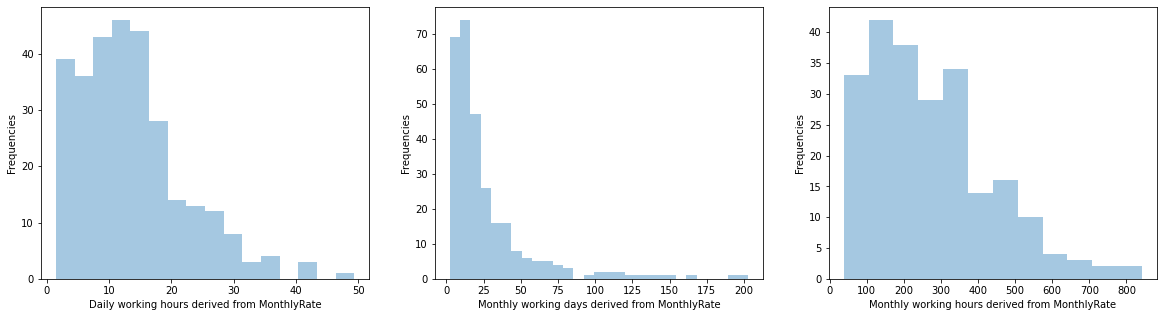

In [88]:
working_hours_in_a_month = []
working_daily_hours = []
working_days = []
i = 0
employees_who_work_more_than_720_hours = []
for row in df.itertuples():
    hours = row.DailyRate / row.HourlyRate
    days = row.MonthlyRate / row.DailyRate
    if row.MonthlyRate > row.MonthlyIncome:
        m_hours = row.MonthlyRate / row.HourlyRate
    else:
        m_hours = row.MonthlyIncome / row.HourlyRate
    working_daily_hours.append(hours)
    working_days.append(days)
    working_hours_in_a_month.append(m_hours)
    if m_hours > 720:
        employees_who_work_more_than_720_hours.append(i)
    i += 1
    
fig = plt.subplots(figsize=(20, 5))
fig_dims = (1, 3)

ax = plt.subplot2grid(fig_dims, (0, 0))
sns.distplot(working_daily_hours, kde=False)
plt.xlabel("Daily working hours derived from MonthlyRate")
plt.ylabel("Frequencies")

ax = plt.subplot2grid(fig_dims, (0, 1))
sns.distplot(working_days, kde=False)
plt.xlabel("Monthly working days derived from MonthlyRate")
plt.ylabel("Frequencies")

ax = plt.subplot2grid(fig_dims, (0, 2))
sns.distplot(working_hours_in_a_month, kde=False)
plt.xlabel("Monthly working hours derived from MonthlyRate")
plt.ylabel("Frequencies")

employees_who_work_more_than_24_hours = len([x for x in working_daily_hours if x > 24])
employees_who_work_more_than_30_days = len([x for x in working_days if x > 30])
print("employees_who_work_more_than_24_hours = ", employees_who_work_more_than_24_hours)
print("employees_who_work_more_than_30_days = ", employees_who_work_more_than_30_days)
print("employees_who_work_more_than_720_hours = ", len(employees_who_work_more_than_720_hours))
plt.show()

In [89]:
print("Age < TotalWorkingYears: ", len(get_age_difference("TotalWorkingYears")))
print("Age < YearsAtCompany: ", len(get_age_difference("YearsAtCompany")))
print("Age < YearsInCurrentRole: ", len(get_age_difference("YearsInCurrentRole")))
print("Age < YearsSinceLastPromotion: ", len(get_age_difference("YearsSinceLastPromotion")))
print("Age < YearsWithCurrManager: ", len(get_age_difference("YearsWithCurrManager")))

Age < TotalWorkingYears:  61
Age < YearsAtCompany:  0
Age < YearsInCurrentRole:  10
Age < YearsSinceLastPromotion:  5
Age < YearsWithCurrManager:  9


In [90]:
print("YearsInCurrentRole > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                  "YearsInCurrentRole", "TotalWorkingYears")))
print("YearsAtCompany > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                    "YearsAtCompany", "TotalWorkingYears")))
print("YearsWithCurrManager > YearsAtCompany: ", len(get_column1_greater_than_column2_difference(
                                                                 "YearsWithCurrManager", "YearsAtCompany")))
print("YearsWithCurrManager > TotalWorkingYears: ", len(get_column1_greater_than_column2_difference(
                                                                 "YearsWithCurrManager", "TotalWorkingYears")))
print("HourlyRate > DailyRate: ", len(get_column1_greater_than_column2_difference(
                                                                                  "HourlyRate", "DailyRate")))
print("HourlyRate > MonthlyRate: ", len(get_column1_greater_than_column2_difference(
                                                                                  "HourlyRate", "MonthlyRate")))
print("HourlyRate > MonthlyIncome: ", len(get_column1_greater_than_column2_difference(
                                                                                "HourlyRate", "MonthlyIncome")))
print("DailyRate > MonthlyRate: ", len(get_column1_greater_than_column2_difference(
                                                                               "DailyRate", "MonthlyRate")))
print("DailyRate > MonthlyIncome: ", len(get_column1_greater_than_column2_difference(
                                                                                  "DailyRate", "MonthlyIncome")))
print("YearsSinceLastPromotion > YearsInCurrentRole: ", len(get_column1_greater_than_column2_difference(
                                                            "YearsSinceLastPromotion",  "YearsInCurrentRole")))
tmp_res = df[(df["YearsInCurrentRole"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)].shape[0]
print("YearsInCurrentRole > YearsAtCompany and NumCompaniesWorked = 0: ", tmp_res)
tmp_res = df[(df["YearsSinceLastPromotion"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)].shape[0]
print("YearsSinceLastPromotion > YearsAtCompany and NumCompaniesWorked = 0: ", tmp_res)

YearsInCurrentRole > TotalWorkingYears:  0
YearsAtCompany > TotalWorkingYears:  69
YearsWithCurrManager > YearsAtCompany:  89
YearsWithCurrManager > TotalWorkingYears:  0
HourlyRate > DailyRate:  0
HourlyRate > MonthlyRate:  0
HourlyRate > MonthlyIncome:  0
DailyRate > MonthlyRate:  0
DailyRate > MonthlyIncome:  0
YearsSinceLastPromotion > YearsInCurrentRole:  34
YearsInCurrentRole > YearsAtCompany and NumCompaniesWorked = 0:  15
YearsSinceLastPromotion > YearsAtCompany and NumCompaniesWorked = 0:  4


In [91]:
# remove incosistent records
to_drop_indexes = set()
# add employees_who_work_more_than_720_hours to row's indexes to eliminate
for elem in employees_who_work_more_than_720_hours:
    to_drop_indexes.add(elem)

to_drop_indexes = to_drop_indexes.union(set(list(df.index[df["DailyRate"] > df["MonthlyIncome"]])))
to_drop_indexes = to_drop_indexes.union(set(get_age_difference("YearsInCurrentRole")))
to_drop_indexes = to_drop_indexes.union(set(get_age_difference("YearsSinceLastPromotion")))
to_drop_indexes = to_drop_indexes.union(set(list(df.index[df["YearsSinceLastPromotion"] > df["YearsInCurrentRole"]])))
tmp_list = df.index[(df["YearsInCurrentRole"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)]
to_drop_indexes = to_drop_indexes.union(set(tmp_list))
tmp_list = df.index[(df["YearsSinceLastPromotion"] > df["YearsAtCompany"]) & (df["NumCompaniesWorked"] == 0)]
to_drop_indexes = to_drop_indexes.union(set(tmp_list))

df.drop(list(to_drop_indexes), axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print("dropped rows = ", len(to_drop_indexes), sep="\t")

df.shape

dropped rows = 	58


(236, 36)

<h2> Switch MonthlyIncome and MonthlyRate rows, if MonthlyIncome >= MonthlyRate</h2> 

In [92]:
df[(df["MonthlyIncome"]) >= (df["MonthlyRate"])].shape[0]

37

In [93]:
index1 = df.columns.get_loc("MonthlyIncome")
index2 = df.columns.get_loc("MonthlyRate")
index3 = df.columns.get_loc("TaxRate")

# switch biased records 
data1 = []
data2 = []
for row in df.itertuples():
    if row.MonthlyIncome > row.MonthlyRate:
        data1.append(row.MonthlyRate)
        data2.append(row.MonthlyIncome)
    else:
        data1.append(row.MonthlyIncome)
        data2.append(row.MonthlyRate)

# correct TaxRate feature 
data3 = []
for i in range(0, len(data1)):
    tax_rate = ((data2[i] - data1[i]) / data2[i])
    try:
        computed_income_floor = math.floor(data2[i] - data2[i]*tax_rate)
        computed_income_ceil = math.ceil(data2[i] - data2[i]*tax_rate)
        if computed_income_floor == data1[i] or computed_income_ceil == data1[i]:
            data3.append(tax_rate)  
        else:
            print("error")
            sys.exit(-1)
    except ValueError:  # omitt NaN values
        data3.append(np.NaN) 

del df["MonthlyIncome"]
del df["MonthlyRate"]
del df["TaxRate"]

df.insert(index1, 'MonthlyIncome', data1)
df.insert(index2, 'MonthlyRate', data2)
df.insert(index3, 'TaxRate', data3)
df.shape

(236, 36)

In [94]:
df[(df["MonthlyIncome"]) >= (df["MonthlyRate"])].shape[0]

0

<h2> Remove irrilevant features from Test Set </h2>

In [95]:
to_drop = ["MaritalStatus", "EducationField", "YearsSinceLastPromotion", 
           "HourlyRate", "DailyRate", "YearsWithCurrManager", "TotalWorkingYears", "Over18",
           "PerformanceRating", "StandardHours"]

for column_name in to_drop:
    del df[column_name]

# check dropping output
print(df.shape)

(236, 26)


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       206 non-null    float64
 1   Attrition                 236 non-null    object 
 2   BusinessTravel            217 non-null    object 
 3   Department                236 non-null    object 
 4   DistanceFromHome          236 non-null    int64  
 5   Education                 236 non-null    int64  
 6   EnvironmentSatisfaction   236 non-null    int64  
 7   Gender                    223 non-null    object 
 8   JobInvolvement            236 non-null    int64  
 9   JobLevel                  236 non-null    int64  
 10  JobRole                   236 non-null    object 
 11  JobSatisfaction           236 non-null    int64  
 12  MonthlyIncome             182 non-null    float64
 13  MonthlyRate               236 non-null    float64
 14  NumCompani

<h2>Save cleaned Test Set on file</h2> 

In [97]:
df.to_csv(data_directory + "Cleaned_Test_HR_Employee_Attrition.csv", index=False, header=True)